In [1]:
from torchvision.models.resnet import ResNet, BasicBlock,resnet152
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
from torch.utils.data import DataLoader
from Natasha1 import Natasha1
from Natasha2 import Natasha2
from utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [2]:
import warnings
warnings.filterwarnings('ignore')

# MNIST

In [3]:
from train import train_val_Mnist

In [ ]:
'''
learning curves have the following information:
train_loss
validation_loss
precision
recall
F1
accuracy
'''

In [35]:
learning_curves = train_val_Mnist(algorithm='Adam', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm Adam
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.2136744357375448, validation loss: 2.0340933799743652
	     precision: 0.1873
	        recall: 0.2268
	            F1: 0.1536
	      accuracy: 0.2313



Epoch 2/10, training loss: 0.1800887617729366, validation loss: 1.5833097696304321
	     precision: 0.3099
	        recall: 0.4040
	            F1: 0.2998
	      accuracy: 0.4192



Epoch 3/10, training loss: 0.14779494013359298, validation loss: 1.139854907989502
	     precision: 0.6322
	        recall: 0.6081
	            F1: 0.5526
	      accuracy: 0.6201



Epoch 4/10, training loss: 0.09939112617517076, validation loss: 0.8948437571525574
	     precision: 0.7530
	        recall: 0.7362
	            F1: 0.7092
	      accuracy: 0.7468



Epoch 5/10, training loss: 0.08929026813141064, validation loss: 0.7623297572135925
	     precision: 0.7894
	        recall: 0.7759
	            F1: 0.7548
	      accuracy: 0.7848



Epoch 6/10, training loss: 0.07643553856085104, validation loss: 0.6831141114234924
	     precision: 0.7986
	        recall: 0.7886
	            F1: 0.7692
	      accuracy: 0.7986



Epoch 7/10, training loss: 0.06714564587261632, validation loss: 0.6271374821662903
	     precision: 0.8209
	        recall: 0.8049
	            F1: 0.7893
	      accuracy: 0.8136



Epoch 8/10, training loss: 0.06727769233778849, validation loss: 0.5876691341400146
	     precision: 0.8337
	        recall: 0.8236
	            F1: 0.8095
	      accuracy: 0.8298



Epoch 9/10, training loss: 0.0574006733419036, validation loss: 0.5520089268684387
	     precision: 0.8508
	        recall: 0.8416
	            F1: 0.8301
	      accuracy: 0.8464



Epoch 10/10, training loss: 0.061815958478049174, validation loss: 0.523491621017456
	     precision: 0.8546
	        recall: 0.8460
	            F1: 0.8348
	      accuracy: 0.8511
Training time: 50.41879630088806s


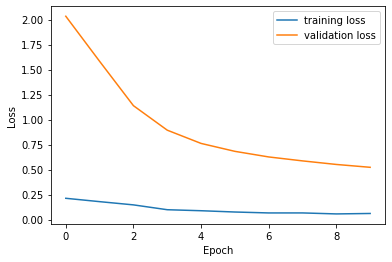

In [36]:
import matplotlib.pyplot as plt
from numpy import *

train_loss = learning_curves['train_loss']
ax = plt.axes()
ax.plot(learning_curves['train_loss'], label='training loss')
ax.plot(learning_curves['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [37]:
learning_curves = train_val_Mnist(algorithm='SGD', cuda=0, epochs=10, train_portion=0.1, model='MnistResNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm SGD
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.05538279356669261, validation loss: 0.21521784365177155
	     precision: 0.9431
	        recall: 0.9416
	            F1: 0.9365
	      accuracy: 0.9420



Epoch 2/10, training loss: 0.01956587415069405, validation loss: 0.1364816129207611
	     precision: 0.9638
	        recall: 0.9621
	            F1: 0.9591
	      accuracy: 0.9622



Epoch 3/10, training loss: 0.013772373935624735, validation loss: 0.11125200241804123
	     precision: 0.9698
	        recall: 0.9681
	            F1: 0.9657
	      accuracy: 0.9688



Epoch 4/10, training loss: 0.011362709196359873, validation loss: 0.08239094167947769
	     precision: 0.9745
	        recall: 0.9743
	            F1: 0.9720
	      accuracy: 0.9744



Epoch 5/10, training loss: 0.009743484839209234, validation loss: 0.0752263218164444
	     precision: 0.9781
	        recall: 0.9781
	            F1: 0.9761
	      accuracy: 0.9777



Epoch 6/10, training loss: 0.007598718822892032, validation loss: 0.06484945118427277
	     precision: 0.9800
	        recall: 0.9803
	            F1: 0.9782
	      accuracy: 0.9801



Epoch 7/10, training loss: 0.00539836191387573, validation loss: 0.06473106145858765
	     precision: 0.9808
	        recall: 0.9809
	            F1: 0.9789
	      accuracy: 0.9802



Epoch 8/10, training loss: 0.005432165758028976, validation loss: 0.05883169546723366
	     precision: 0.9815
	        recall: 0.9816
	            F1: 0.9796
	      accuracy: 0.9816



Epoch 9/10, training loss: 0.00668371369494304, validation loss: 0.055951740592718124
	     precision: 0.9818
	        recall: 0.9813
	            F1: 0.9798
	      accuracy: 0.9813



Epoch 10/10, training loss: 0.006378594938832432, validation loss: 0.05277876555919647
	     precision: 0.9830
	        recall: 0.9836
	            F1: 0.9817
	      accuracy: 0.9833
Training time: 71.07781887054443s


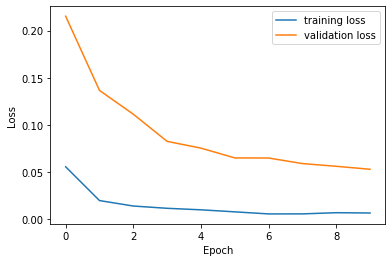

In [38]:
import matplotlib.pyplot as plt
from numpy import *

train_loss = learning_curves['train_loss']
ax = plt.axes()
ax.plot(learning_curves['train_loss'], label='training loss')
ax.plot(learning_curves['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

# Linear model for debugging

In [ ]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [ ]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 10

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [ ]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
optimizer = Natasha2(model.parameters(), alpha=learningRate)

In [ ]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward(retain_graph=True)
    
    hessian_matrix = eval_hessian(loss, model)
    # update parameters
    optimizer.step(hessian_matrix)

    print('epoch {}, loss {}'.format(epoch, loss.item()))